# Final Project: COGS118A

### Third dataset: EEG Alcohol Dataset

# 1. Setup

- Import necessary packages.
- Load dataset

In [295]:
# Installation
!pip install ucimlrepo

# General
import numpy as np
import os
import pandas as pd

# Data Formats
import gzip
import tarfile
import arff
from scipy.io import arff

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE

# Data Split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

In [296]:
dataset_folder = "/Users/henrikformoe/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Github/final_project_COGS118A/eeg+database"
train_file = os.path.join(dataset_folder, "SMNI_CMI_TRAIN.tar.gz")
test_file = os.path.join(dataset_folder, "SMNI_CMI_TEST.tar.gz")

In [297]:
# Extract train and test datasets

if tarfile.is_tarfile(train_file):
    with tarfile.open(train_file, 'r:gz') as tar:
        tar.extractall(path=os.path.join(dataset_folder, "train_data"))
        print("Extracted train dataset.")

if tarfile.is_tarfile(test_file):
    with tarfile.open(test_file, 'r:gz') as tar:
        tar.extractall(path=os.path.join(dataset_folder, "test_data"))
        print("Extracted test dataset.")

/var/folders/kb/t8njst5d1qg_hr3b0_jq9s2r0000gn/T/ipykernel_35638/1872243357.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=os.path.join(dataset_folder, "train_data"))


Extracted train dataset.


/var/folders/kb/t8njst5d1qg_hr3b0_jq9s2r0000gn/T/ipykernel_35638/1872243357.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=os.path.join(dataset_folder, "test_data"))


Extracted test dataset.


In [298]:
train_folder = os.path.join(dataset_folder, "train_data")
test_folder = os.path.join(dataset_folder, "test_data")

In [299]:
def process_gz_files(base_dir):
    gz_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.gz'):
                gz_files.append(os.path.join(root, file))

    all_data = []
    for gz_file in gz_files:
        with gzip.open(gz_file, 'rt') as f:
            content = f.readlines()
            data_lines = [line.strip() for line in content if not line.startswith('#')]
            for line in data_lines:
                all_data.append(line.split())
    
    return pd.DataFrame(all_data, columns=["Trial", "Channel", "Index", "Value"])

In [300]:
# Process training and testing datasets

eeg_train = process_gz_files(train_folder)
eeg_test = process_gz_files(test_folder)

In [303]:
# Dataset overview

print("\nTraining Dataset:")
print(f"Shape: {eeg_train.shape}")
print(eeg_train.info())
print(eeg_train.head())

print("\nTesting Dataset:")
print(f"Shape: {eeg_test.shape}")
print(eeg_test.info())
print(eeg_test.head())


Training Dataset:
Shape: (9830400, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830400 entries, 0 to 9830399
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Trial    object
 1   Channel  object
 2   Index    object
 3   Value    object
dtypes: object(4)
memory usage: 300.0+ MB
None
  Trial Channel Index   Value
0     0     FP1     0  -2.462
1     0     FP1     1  -2.462
2     0     FP1     2  -1.485
3     0     FP1     3  -0.509
4     0     FP1     4  -0.020

Testing Dataset:
Shape: (9830400, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830400 entries, 0 to 9830399
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Trial    object
 1   Channel  object
 2   Index    object
 3   Value    object
dtypes: object(4)
memory usage: 300.0+ MB
None
  Trial Channel Index   Value
0    51     FP1     0   3.642
1    51     FP1     1   0.712
2    51     FP1     2  -0.264
3    51     FP1     3  -0.264
4    51     FP1     4  

# 2. Exploratory Data Analysis and Preprocessing

- Summarize datasets. 
- Visualize features and check distributions.

- Alcoholic = 1, Control = 0

In [199]:
print("Duplicates Check:")
print(f"EEG Alcohol Dataset Test: {eeg_test.duplicated().sum()} duplicates")
print(f"EEG Alcohol Dataset Train: {eeg_train.duplicated().sum()} duplicates")

Duplicates Check:
EEG Alcohol Dataset Test: 24638 duplicates
EEG Alcohol Dataset Train: 27277 duplicates


eeg = eeg.drop_duplicates()

In [231]:
# Remove missing values

eeg = eeg_test.dropna()
eeg = eeg_train.dropna()

In [232]:
# Identify the target variable (e.g., 'Alcoholic' or 'Control')
# Convert target variable to numeric

eeg_train['Target'] = eeg_train.iloc[:, 0].apply(lambda x: 'Alcoholic' if 'a_' in x else 'Control')
eeg_train['Target'] = eeg_train['Target'].map({'Alcoholic': 1, 'Control': 0})

eeg_test['Target'] = eeg_test.iloc[:, 0].apply(lambda x: 'Alcoholic' if 'a_' in x else 'Control')
eeg_test['Target'] = eeg_test['Target'].map({'Alcoholic': 1, 'Control': 0})

In [239]:
# Remove unnecessary columns

eeg_train = eeg_train.drop(columns=[eeg_train.columns[0]])
eeg_test = eeg_test.drop(columns=[eeg_test.columns[0]]) 

In [240]:
# Separate features and target

X_train = eeg_train.drop(columns=['Target', 'Value'])
y_train = eeg_train['Target']

X_test = eeg_test.drop(columns=['Target', 'Value']) 
y_test = eeg_test['Target']

In [255]:
# Extract numeric feature data for training and testing

X_train_numeric = eeg_train[['Value']].astype(float)
X_test_numeric = eeg_test[['Value']].astype(float)

# Extract numeric feature data for validation (split from training data)

X_train_numeric, X_val_numeric, y_train, y_val = train_test_split(
    X_train_numeric, eeg_train['Target'], test_size=0.2, random_state=42
)

In [252]:
# Print dataset shapes for verification

print("Shapes of processed datasets:")
print("X_train_numeric shape:", X_train_numeric.shape)
print("X_val_numeric shape:", X_val_numeric.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

Shapes of processed datasets:
X_train_numeric shape: (7864320, 1)
X_val_numeric shape: (1966080, 1)
y_train shape: (7864320,)
y_val shape: (1966080,)


In [261]:
# Scale data for RF and ANN

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

print("Training features shape (scaled):", X_train_scaled.shape)
print("Validation features shape (scaled):", X_val_scaled.shape)
print("Testing features shape (scaled):", X_test_scaled.shape)

Training features shape (scaled): (7864320, 1)
Validation features shape (scaled): (1966080, 1)
Testing features shape (scaled): (9830400, 1)


In [263]:
# Normalize for KNN

X_train_norm = normalize(X_train_numeric, axis=0)
X_val_norm = normalize(X_val_numeric, axis=0)
X_test_norm = normalize(X_test_numeric, axis=0)

print("Training features shape (normalized):", X_train_norm.shape)
print("Validation features shape (normalized):", X_val_norm.shape)
print("Testing features shape (normalized):", X_test_norm.shape)

Training features shape (normalized): (7864320, 1)
Validation features shape (normalized): (1966080, 1)
Testing features shape (normalized): (9830400, 1)


## Visualize data

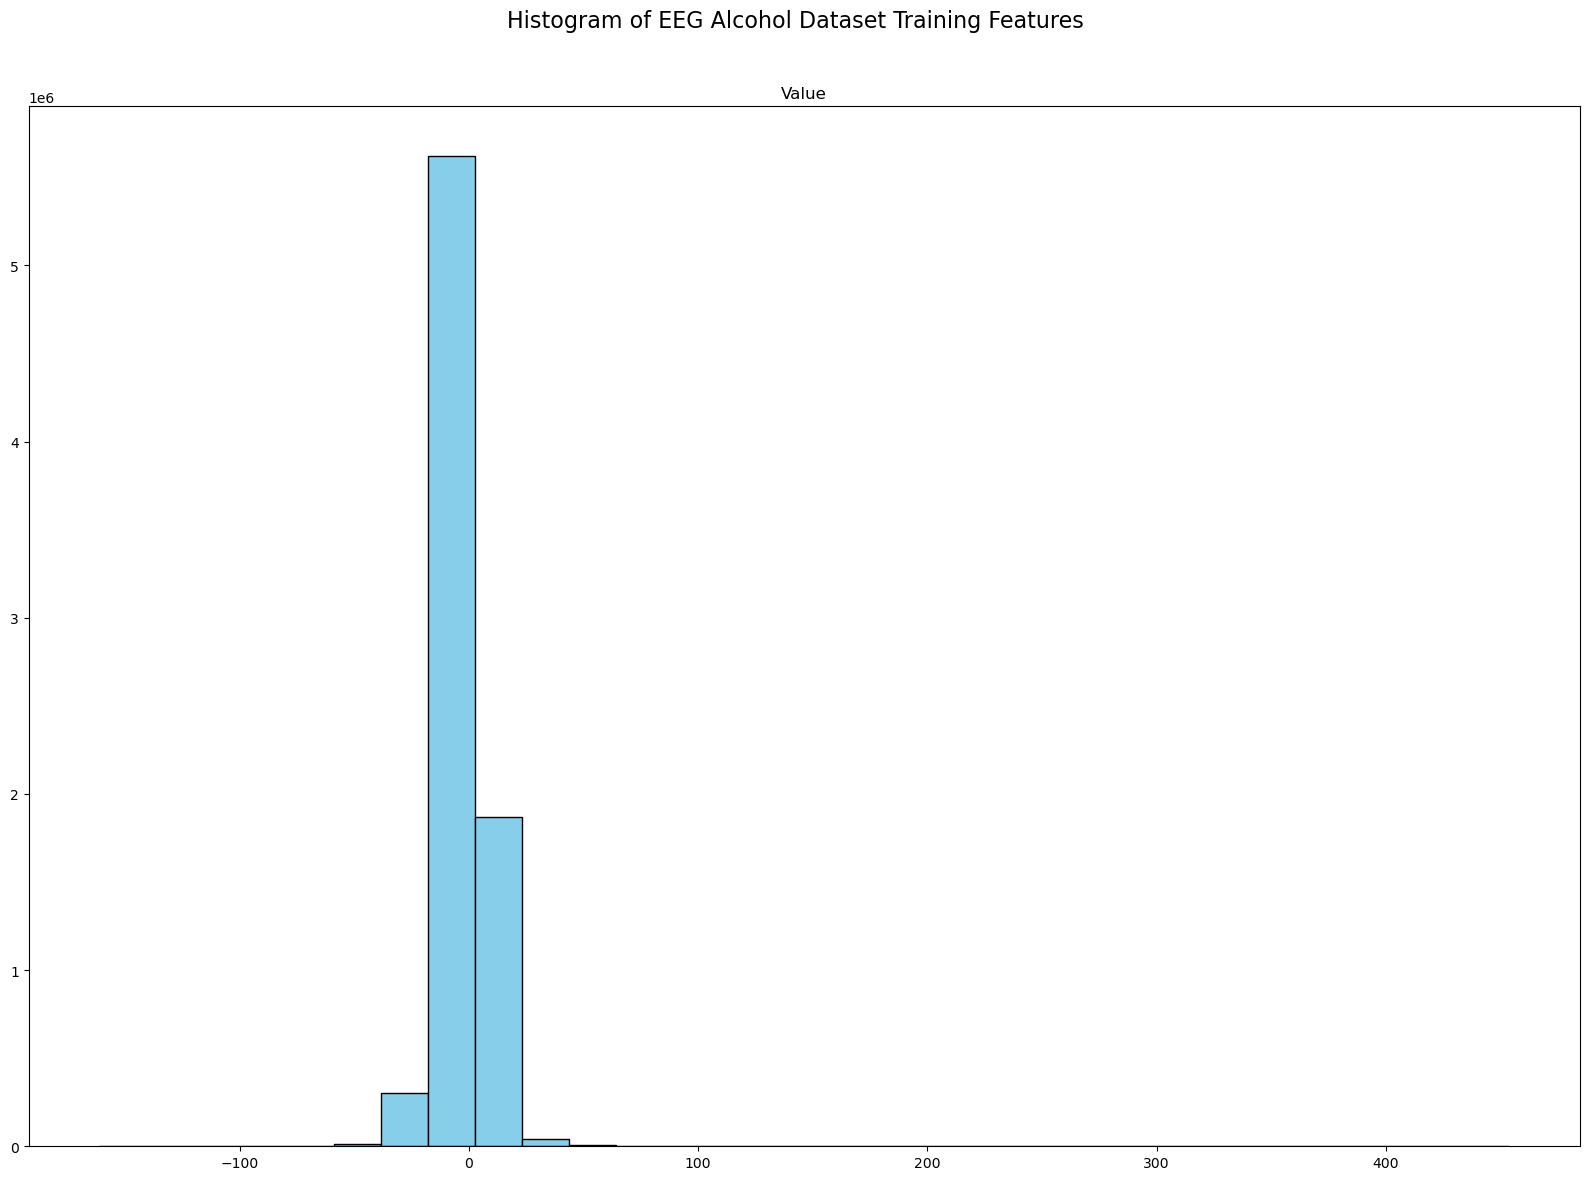

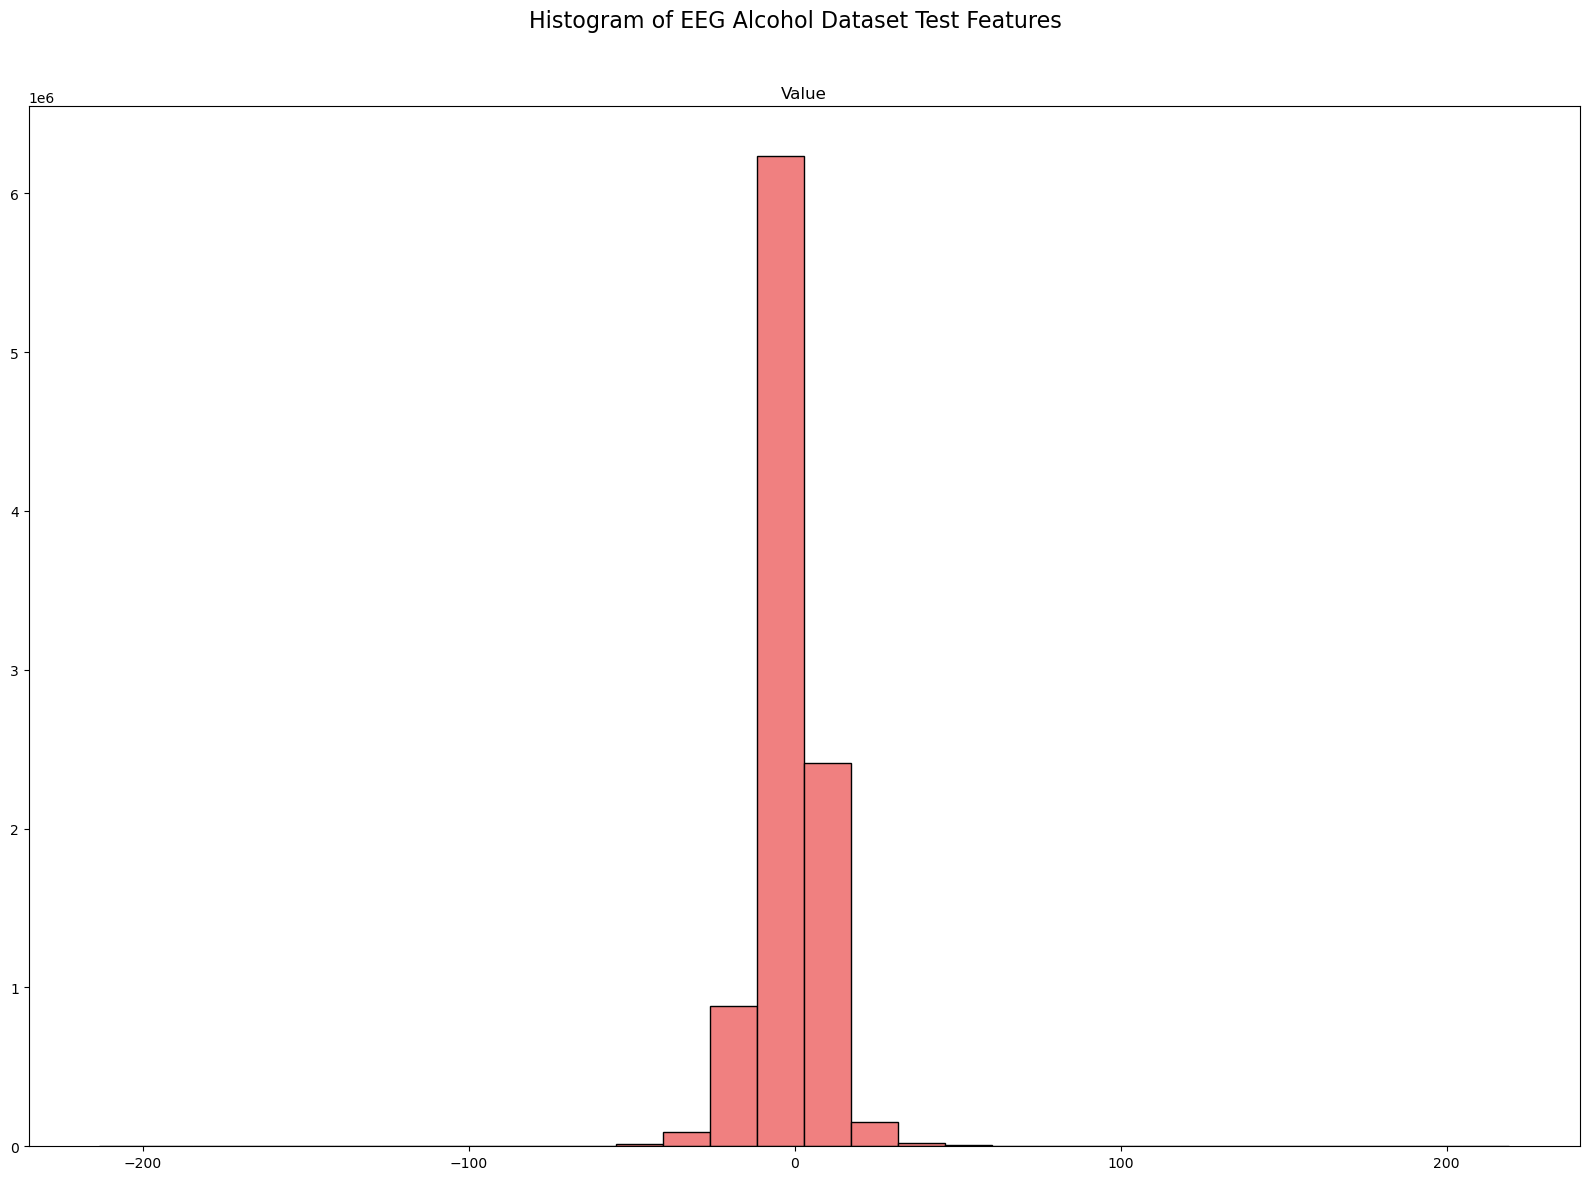

In [284]:
# histogram for training data
X_train_numeric.hist(
    figsize=(16, 12), bins=30, edgecolor='black', color='skyblue', grid=False
)
plt.suptitle('Histogram of EEG Alcohol Dataset Training Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# histogram for test data

X_test_numeric.hist(
    figsize=(16, 12), bins=30, edgecolor='black', color='lightcoral', grid=False
)
plt.suptitle('Histogram of EEG Alcohol Dataset Test Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Converting target to int

eeg['eyeDetection'] = eeg['eyeDetection'].astype(int)
numeric_eeg = eeg.select_dtypes(include=[np.number])
corr = numeric_eeg.corr()

# Select numeric columns

print(numeric_eeg.columns)
print([col for col in numeric_eeg.columns if 'eyeDetection' in col])

# Select features with strong correlation

selected_features = target_corr[abs(target_corr) > 0.3].index
reduced_data = eeg[selected_features]
print(reduced_data.head())

scaled_eeg = pd.DataFrame(X_train_scaled, columns=X.columns)
scaled_eeg['eyeDetection'] = y_train.reset_index(drop=True)

# Pairplot for scaled data
sns.pairplot(scaled_eeg, vars=['FC6', 'F4', 'T8', 'F3'], hue='eyeDetection', diag_kind="kde")
plt.show()

# 3. Preprocessing

# Check for null values

print(eeg.isnull().sum())

# Normalize numeric columns

numeric_columns = eeg.select_dtypes(include=[np.number]).columns

scaler = MinMaxScaler()

eeg_normalized = eeg.copy()
eeg_normalized[numeric_columns] = scaler.fit_transform(eeg[numeric_columns])

print(eeg_normalized.head())

# Separate features and target variable, and split into training, validation and test sets

X = eeg_normalized.drop(columns=['eyeDetection'])
y = eeg_normalized['eyeDetection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Testing target shape:", y_test.shape)

# 4. Train and tune Models

- Train Random Forests, KNN, and Neural Networks
- Compare performances

## Random Forest Classifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_val_rf = rf.predict(X_val_scaled)
print("Random Forest Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_rf))

# GridSearchCV for hyperparameter tuning for RF

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

## K-Nearest Neighbors Classifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_norm, y_train)

y_pred_val_knn = knn.predict(X_val_norm)

print("K-Nearest Neighbors Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_knn))

# GridSearchCV for hyperparameter tuning for KNN 

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_norm, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
y_pred = grid_search.best_estimator_.predict(X_test_norm)
print(classification_report(y_test, y_pred))

## Neural Network Classifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred_val_mlp = mlp.predict(X_val_scaled)

print("Neural Network Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_mlp))

# GridSearchCV for hyperparameter tuning for ANN

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'max_iter': [1500, 2000],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}

mlp = MLPClassifier(random_state=42)

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

y_pred_val_mlp = grid_search.best_estimator_.predict(X_val_scaled)
print("Neural Network Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_mlp))

## Comparison of models

# Metrics for each model deployed on validation data from EEG Eye State Dataset

models = ['Random Forest', 'K-Nearest Neighbors', 'Neural Network']
accuracies = [0.92, 0.97, 0.87]
macro_f1_scores = [0.92, 0.97, 0.87]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, macro_f1_scores, width, label='Macro F1-Score', alpha=0.8)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance on Validation Data from EEG Eye State Dataset', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 5. Evaluation

## Random Forest Classifier

print("Random Forest Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_rf))

y_pred_test_rf = rf.predict(X_test_scaled)
print("Random Forest Classifier Performance on Test Data:")
print(classification_report(y_test, y_pred_test_rf))

# Feature importance from trained Random Forest model

feature_importances = rf.feature_importances_

features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features)

plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Random Forest - EEG EYE State Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## K-Nearest Neighbors Classifier

print("K-Nearest Neighbors Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_knn))

y_pred_test_knn = knn.predict(X_test_norm)
print("K-Nearest Neighbors Classifier Performance on Test Data:")
print(classification_report(y_test, y_pred_test_knn))

## Neural Network Classifier

print("Neural Network Classifier Performance on Validation Data:")
print(classification_report(y_val, y_pred_val_mlp))

y_pred_test_mlp = mlp.predict(X_test_scaled)
print("Neural Network Classifier Performance on Test Data:")
print(classification_report(y_test, y_pred_test_mlp))

## Comparison of final models on test data:

odels = ['Random Forest', 'K-Nearest Neighbors', 'Neural Network']
accuracies = [0.92, 0.97, 0.88]
macro_f1_scores = [0.92, 0.97, 0.88]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, macro_f1_scores, width, label='Macro F1-Score', alpha=0.8, color='orange')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance on Test Data from EEG Eye State Dataset', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()